# PointNet for particle flow

<div class="alert alert-block alert-success">
This notebook focuses on exploratory data analysis to showcase basic logging functionalities.

**Main changes:** 

- introduce basic logging to Weights & Biases to keep track of data features

</div>

## Problem

This dataset contains a Monte Carlo simulation of $\rho^{\pm} \rightarrow \pi^{\pm} + \pi^0$ decays and the corresponding detector response. Specifically, the data report the measured response of **i) tracker** and **ii) calorimeter**, along with the true pyshical quantitites that generated those measurements.

<div class="alert alert-block alert-info">
This means that we expect one track per event, with mainly two energy blobs (clusters of cells) in the calorimeter.
</div>

The final **goal** is to associate the cell signals observed in the calorimeter to the track that caused those energy deposits.

## Method

The idea is to leverage a **point cloud** data representation to combine tracker and calorimeter information so to associate cell hits to the corresponding track. We will use a [**PointNet**](https://openaccess.thecvf.com/content_cvpr_2017/papers/Qi_PointNet_Deep_Learning_CVPR_2017_paper.pdf) model that is capable of handling this type of data, framed as a **semantic segmentation** approach. More precisely, this means that:
- we represent each hit in the detector as a point in the point cloud: x, y, z coordinates + additional features ("3+"-dimensional point)
- the **learning task** will be binary classification at hit level: for each cell the model learns whether its energy comes mostly from the track (class 1) or not (class 0)

## Data structure

<div class="alert alert-block alert-info">

This dataset is organized as follows:
 - for each event, we create a **sample** (i.e. point cloud)
 - each sample contains all hits in a cone around a track of the event, called **focal track**
     - the cone includes all hits within some $\Delta R$ distance of the track
     - if an event has multiple tracks, then we have more samples per event
     - since different samples have possibly different number of hits, **we pad all point clouds to ensure they have same size** (needed since the model requires inputs of same size)

</div>

## Settings & config

This section collects all configuration variables and training/model hyperparameters. 

The idea is to put it at the top so that it is easy to find and edit.

In [1]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

# path settings
REPO_BASEPATH = Path().cwd().parent
DATA_PATH = REPO_BASEPATH / "pnet_data/raw/rho_small.npz"
CODE_PATH = REPO_BASEPATH / "src"
sys.path.append(str(CODE_PATH))
MODEL_CHECKPOINTS_PATH = REPO_BASEPATH / "results" / "models" / "pointnet_baseline.weights.h5"

import wandb
from data_viz import *
from model_utils import *

LABELS = ["unfocus hit", "focus hit"]

# set random seed for reproducibility
SEED = 18
set_global_seeds(SEED)

# data settings
N_TRAIN, N_VAL, N_TEST = 210, 65, 50 # roughly 0.65, 0.2, 0.15

2024-11-26 10:41:25.237460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 10:41:27.386512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Quickstart wandb

In order to use Weights & Biases you need to:

Before you get started, make sure you create an account and install W&B:

1. [Sign up](https://wandb.ai/site) for a free account and then log in to your wandb account (note: free functionalities for academic accounts)
2. Install the wandb library on your machine in a Python 3 environment using pip.
3. Navigate to the [Authorize page](https://wandb.ai/authorize) to create an **API key**, and save it for later use.

Once you have this setup, you just need to import wandb library and login once to authenticate:

```python
import wandb
wandb.login()
# you are prompted to insert access token
```

After logged in, your system should remember your credentials and you can use `wandb` without re-logging every time (unless you specifically want to avoid token caching). Hence, using `wandb` resolves to two simple steps:

- initialize a session (**run** in wandb terms): `wandb.init()`
- log a dictionary with all the quantities you want to keep track of: `wandb.log()`

The logged stuff will be visible on the wandb UI, under your project page (we will see how to create this in this tutorial!). From there you can check all you configurations and results.

Let's start by creating a project on your wandb account:

![](../pnet_data/images/wandb-create-project-blurred.png)

<div class="alert alert-block alert-warning">

For this tutorial you can log directly into `lclissa/mlops-ai_infn` project.
</div>

### Initialize session

This create a wandb run (what collects results of an "experiment"). More info in [documentation](https://docs.wandb.ai/ref/python/init).

In [2]:
#!pip install wandb -y
# wandb.login()
wandb.init(
    project="mlops-ai_infn", # set your project name here
    entity="lclissa", # set under
    name="basic logging", # automatically set if not specified 
    job_type="EDA", # optional: useful to filter different kind of runs in the UI 
    # (e.g. EDA, training, tests...)
    config={
        'DATA_PATH': DATA_PATH
    },
    notes="My first run with wandb" # optional: we can add descriptions as metadata
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lclissa. Use `wandb login --relogin` to force relogin


<div class="alert alert-block alert-warning">

Remember to close the session when finished `wandb.finish`. Typically done automatically, best practice would be to use context managers:

```
with wandb.init(...) as run:
    ...
    wandb.log(...)

```
</div>

## Exploratory Data Analysis (EDA)

In [3]:
# load data
events = np.load(DATA_PATH)["feats"]

In [4]:
### dataset content and types

# n_samples and points_per_sample
print("Data format and shape:")
print(f"{type(events)}\t{events.shape=}\n\n")
# Note: structured numpy array --> columns accessible by name

# dataset columns
print(f"Column\tdtype")
for colname, coltype in events.dtype.descr:
    print(f"{colname}\t:{coltype}")

Data format and shape:
<class 'numpy.ndarray'>	events.shape=(325, 800)


Column	dtype
event_number	:<i4
cell_ID	:<i4
track_ID	:<i4
delta_R	:<f4
truth_cell_focal_fraction_energy	:<f4
truth_cell_non_focal_fraction_energy	:<f4
truth_cell_neutral_fraction_energy	:<f4
truth_cell_total_energy	:<f4
category	:|i1
track_num	:<i4
x	:<f4
y	:<f4
z	:<f4
distance	:<f4
normalized_x	:<f4
normalized_y	:<f4
normalized_z	:<f4
normalized_distance	:<f4
cell_sigma	:<f4
track_chi2_dof	:<f4
track_chi2_dof_cell_sigma	:<f4
cell_E	:<f4
normalized_cell_E	:<f4
track_pt	:<f4
normalized_track_pt	:<f4
track_pt_cell_E	:<f4
normalized_track_pt_cell_E	:<f4


In [5]:
# dataset statistics

n_samples, n_points_per_sample = events.shape

sample_event_ids = events['event_number'][:,0]
event_ids, event_ids_count = np.unique(sample_event_ids, return_counts=True)
n_events = len(event_ids)

print(f"{n_events=}") # old
print(f"{n_samples=}") # old
print(f"{n_points_per_sample=}") # old

n_events=314
n_samples=325
n_points_per_sample=800


## Logging summary stats

Instead of just printing out important information, we can keep track of it by logging to wandb, so that we can access it later for reference:

In [6]:
wandb.log(
    {
        'summary/n_events': n_events,
        'summary/n_samples': n_samples,
        'summary/n_points_per_sample': n_points_per_sample
    }
)

In [7]:
# take one point per sample and check event_number; 
# if event_number is repeated it means we have more samples per that event_number
# we take just one point, since event_number repeated for each point otherwise
n_samples_per_event = np.unique(events['event_number'][:, 0], return_counts=True)

multiple_samples_event_ids = n_samples_per_event[0][n_samples_per_event[1]>1]
print("This events unexpectedly have more than one sample per event... --> TO CHECK")
multiple_samples_event_ids

This events unexpectedly have more than one sample per event... --> TO CHECK


array([826871, 827140, 827188, 827226, 827242, 828437], dtype=int32)

### Number of tracks and cells per event/sample

In [8]:
events_df = pd.DataFrame(events.reshape(-1).T, columns=events.dtype.names)
sample_id_col = np.repeat(np.arange(events.shape[0]), events.shape[1])
events_df['sample_ID'] = sample_id_col

In [9]:
n_tracks_per_sample = events_df.groupby('sample_ID')['track_ID'].max() + 1
np.unique(n_tracks_per_sample, return_counts=True)

(array([1, 2, 3], dtype=int32), array([307,   3,  15]))

In [10]:
n_tracks_per_event = events_df.groupby('event_number')['track_ID'].max() + 1
np.unique(n_tracks_per_event, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([  1, 307,   2,   5]))

In [11]:
n_cells_per_sample = events_df[events_df['cell_ID'] != -1].groupby('sample_ID')['cell_ID'].count()
np.unique(n_cells_per_sample, return_counts=True)

(array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  37,  38,
         39,  40,  41,  42,  45,  46,  47,  48,  49,  51,  53,  56,  61,
         65,  67,  69,  71,  72,  73,  74,  76,  77,  79,  80,  81,  82,
         84,  87,  88,  89,  90,  91,  92,  95,  98, 100, 101, 107, 108,
        109, 110, 111, 112, 113, 118, 119, 120, 122, 123, 125, 126, 127,
        130, 131, 133, 135, 136, 137, 139, 141, 142, 143, 144, 145, 146,
        148, 149, 150, 153, 154, 155, 156, 157, 158, 159, 161, 162, 164,
        165, 166, 170, 174, 176, 177, 178, 181, 182, 184, 185, 186, 187,
        189, 190, 191, 194, 195, 196, 197, 198, 199, 201, 202, 208, 209,
        213, 216, 217, 218, 219, 221, 224, 225, 229, 230, 231, 233, 234,
        235, 236, 237, 239, 240, 242, 246, 247, 248, 249, 250, 251, 252,
        253, 254, 255, 256, 258, 259, 260, 262, 263, 264, 265, 268, 270,
        271, 276, 277, 278, 280, 289, 291, 293, 296, 298, 299, 300, 301,
        310, 314, 320, 323, 330, 331, 334, 338, 339

In [12]:
n_cells_per_event =  events_df[events_df['cell_ID'] != -1].groupby('event_number')['cell_ID'].count()
np.unique(n_cells_per_event, return_counts=True)

(array([  25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          37,   38,   39,   40,   41,   42,   45,   46,   47,   48,   49,
          51,   53,   56,   61,   65,   67,   69,   71,   72,   73,   74,
          76,   77,   79,   80,   81,   82,   84,   87,   88,   89,   90,
          91,   92,   95,   98,  100,  101,  107,  108,  109,  110,  111,
         112,  113,  118,  120,  122,  123,  125,  126,  127,  130,  131,
         133,  135,  136,  137,  139,  141,  142,  143,  144,  145,  146,
         148,  149,  150,  153,  154,  155,  156,  157,  158,  159,  161,
         162,  164,  165,  166,  170,  174,  176,  177,  178,  181,  182,
         184,  185,  186,  187,  189,  190,  191,  194,  195,  196,  197,
         198,  199,  201,  202,  208,  209,  213,  216,  218,  219,  221,
         224,  225,  229,  230,  233,  234,  235,  236,  237,  239,  240,
         242,  246,  247,  248,  249,  250,  251,  252,  254,  255,  256,
         258,  259,  260,  262,  263, 

### Visualizations

It is possible to log several types of data to wandb, including images.

There are various ways to accomplish this:
- log a static image/plot as a wandb.Image() 
- log data as wandb.Table() to enable interactive plotting in wandb UI

More info in the documentation [[1](https://docs.wandb.ai/guides/track/log/plots/), [2](https://docs.wandb.ai/ref/python/data-types/image/)]

### Point clouds 

/tmp/ipykernel_9518/2547836923.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.loc[:, 'target_class'] = np.where(sample_df.truth_cell_focal_fraction_energy < 0.5, -1, 1)


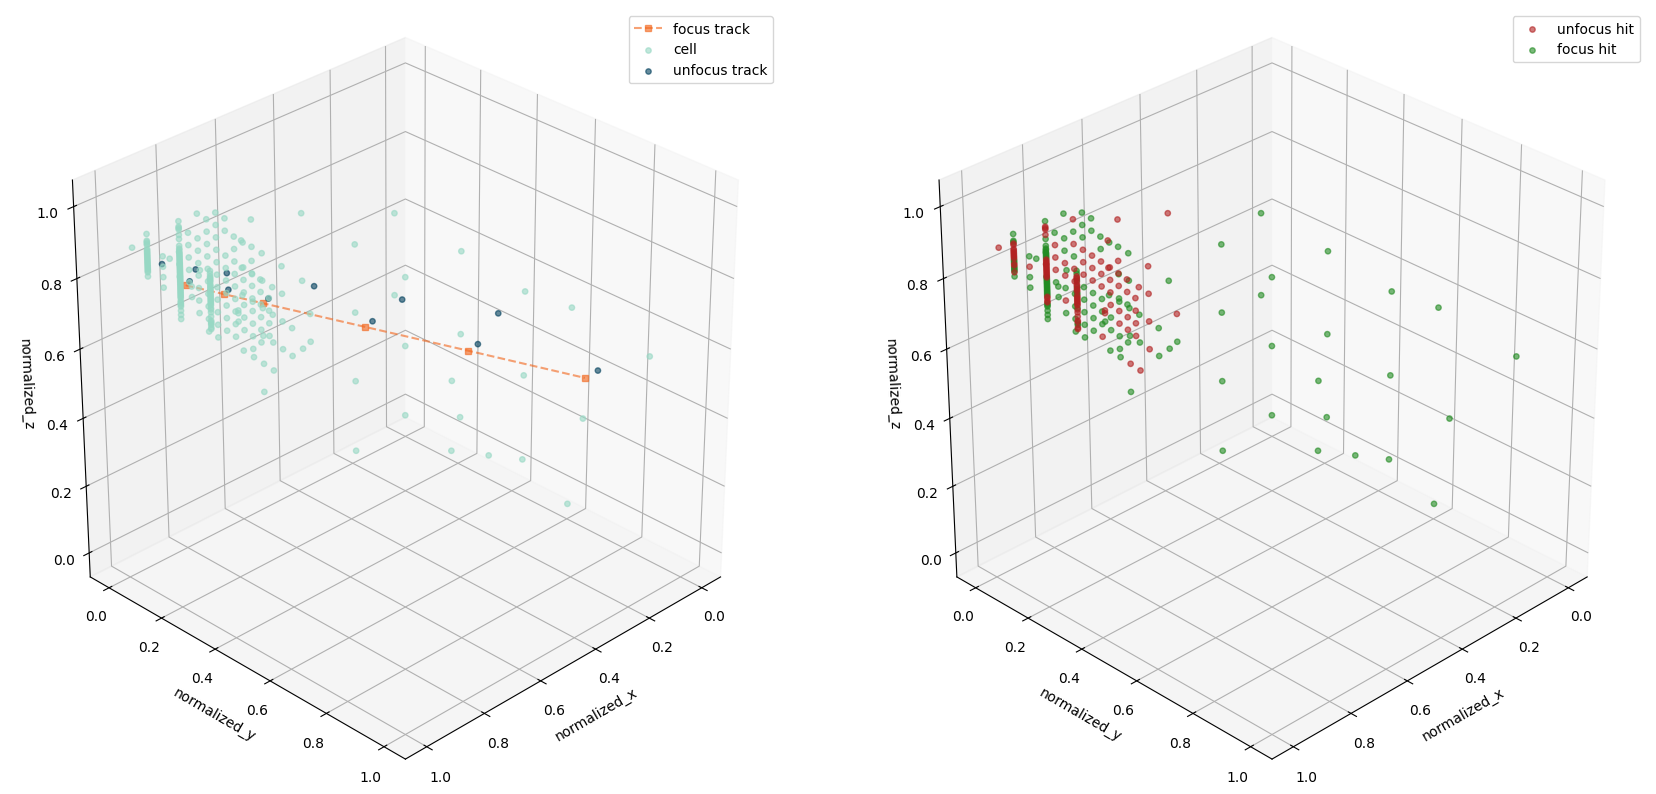

In [13]:
hit_type = {
    # -1: 'padding',
    0: 'focus track',
    1: 'cell',
    2: 'unfocus track'
}
hit_colors = {
    -1: '#4059AD',  # Royal Blue
    0: '#F26419',   # Burnt Orange,
    1: '#97D8C4',   # Mint
    2: '#003F5C',   # Sky Blue
}

class_type = {
    -1: 'unfocus hit',
    1: 'focus hit',
}

class_colors = {-1: 'firebrick', 1: 'forestgreen',}

sample_id = event_id_to_sample_id(events_df, multiple_samples_event_ids[1])[0]
sample_df = events_df.query('sample_ID == @sample_id & category != -1')
sample_df.loc[:, 'target_class'] = np.where(sample_df.truth_cell_focal_fraction_energy < 0.5, -1, 1)

point_cloud_fig = plt.figure(figsize=(20, 8))  # Double the width compared to single plot
ax1 = point_cloud_fig.add_subplot(121, projection='3d')  # 1 row, 2 cols, first plot
ax2 = point_cloud_fig.add_subplot(122, projection='3d')  # 1 row, 2 cols, second plot

panel_left = plot_point_cloud(
    sample_df, fig=point_cloud_fig, ax=ax1,
    x_col='normalized_x', y_col='normalized_y', z_col='normalized_z',
    category_labels=hit_type,
    view_angle=(30, 45),
    point_size=15,
    color_map=hit_colors
)
panel_right = plot_point_cloud(
    sample_df.query('category == 1'), fig=point_cloud_fig, ax=ax2,
    x_col='normalized_x', y_col='normalized_y', z_col='normalized_z',
    category_col='target_class', category_labels=class_type,
    view_angle=(30, 45),
    point_size=15,
    color_map=class_colors
)

plt.show()

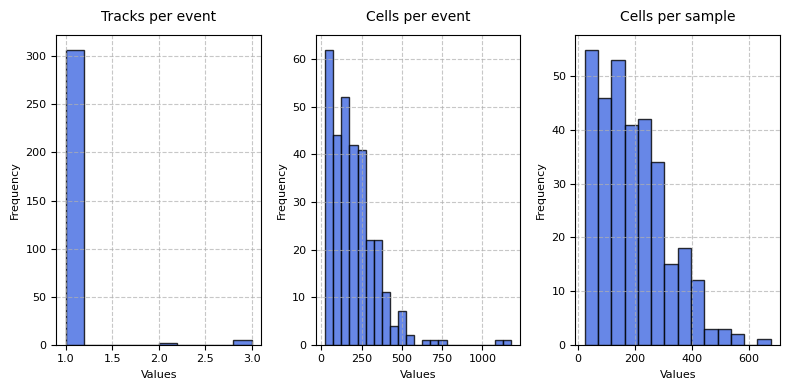

In [14]:
data_dict = {
    'Tracks per event': n_tracks_per_event[1:],
    #'Tracks per sample': n_tracks_per_sample,
    'Cells per event': n_cells_per_event,
    'Cells per sample': n_cells_per_sample
}

# Create plot
histograms_fig = plot_histograms(data_dict, figsize=(8,4), bins='auto', density=False)
plt.show()

### Feature distributions

Here we inspect the distribution of important features to use during training:
 - cell_E: energy measured in calorimeter cells
 - track_pt: momentum measured in the tracker (analogous of energy for track hits)
 - category: type of hit
     - focus track (0)
     - calo cell (1)
     - unfocus track (2)
     - padding (-1)

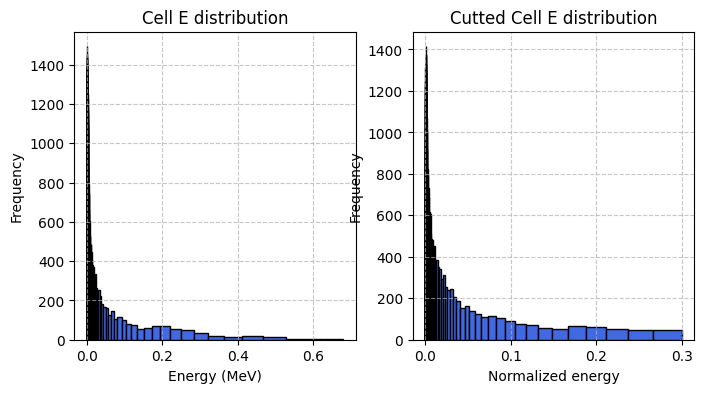

In [15]:
cell_E = events_df.query("category in [1]").normalized_cell_E

n_bins = 100
bins = get_logbins(cell_E, n_bins)

cell_E_fig, axes = plt.subplots(1, 2, figsize=(8,4))

cell_E.hist(bins=bins, color='royalblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Cell E distribution')
axes[0].set_xlabel('Energy (MeV)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, axis='both', linestyle='--', alpha=0.7)

# cutted distribution
cutted_cell_E = cell_E[cell_E < 0.3] # 300 on original scale
bins = get_logbins(cutted_cell_E, n_bins)
cutted_cell_E.hist(bins=bins, color='royalblue', edgecolor='black', ax=axes[1])
plt.title('Cutted Cell E distribution')
plt.xlabel('Normalized energy')
plt.ylabel('Frequency')
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.show()

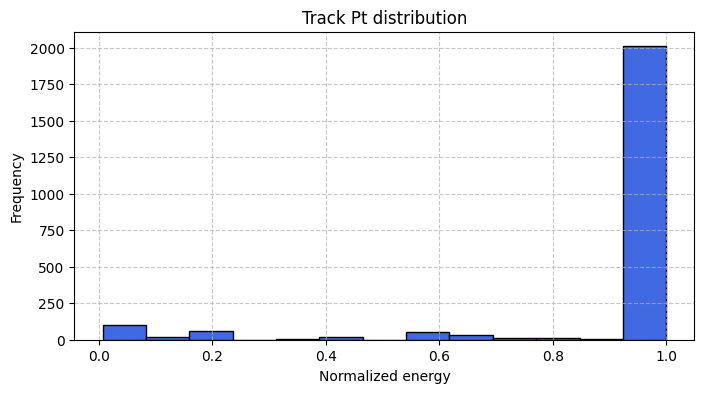

In [16]:
track_Pt_fig = events_df.query("category in [0, 2]").normalized_track_pt.hist(bins='auto', figsize=(8, 4), 
                                                    color='royalblue', edgecolor='black',
                                                    #grid=dict(axis='both', linestyle='--', alpha=0.7)
                                                   )

plt.title('Track Pt distribution')
plt.xlabel('Normalized energy')
plt.ylabel('Frequency')
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.show()

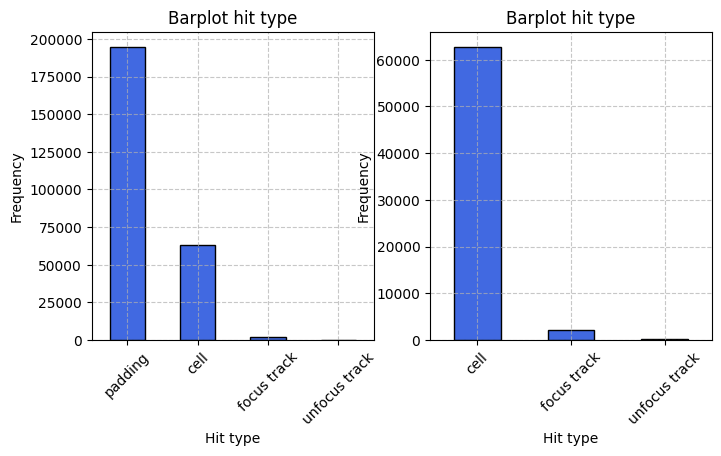

In [17]:
label_map = {
    -1: 'padding',
    0: 'focus track',
    1: 'cell',
    2: 'unfocus track'
}

hit_type_fig, axes = plt.subplots(1, 2, figsize=(8,4))

events_df.category.map(label_map).value_counts().plot(
    kind='bar', color='royalblue', edgecolor='black', rot=45, ax=axes[0])
axes[0].set_title('Barplot hit type')
axes[0].set_xlabel('Hit type')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, axis='both', linestyle='--', alpha=0.7)

# cutted distribution
events_df.query('category != -1').category.map(label_map).value_counts().plot(
    kind='bar', color='royalblue', edgecolor='black', rot=45, ax=axes[1])
plt.title('Barplot hit type')
plt.xlabel('Hit type')
plt.ylabel('Frequency')
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.show()

### Target distribution

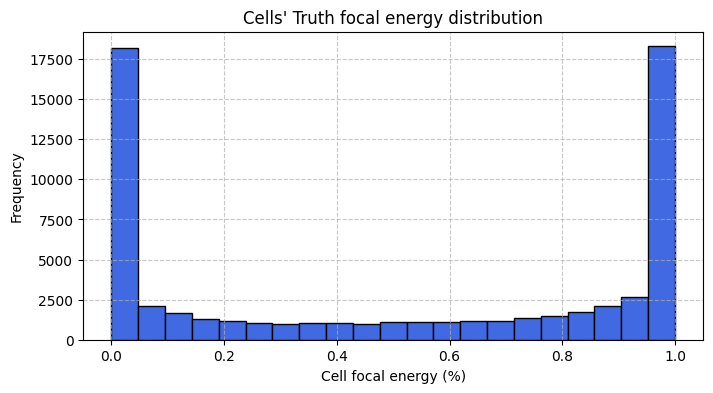

In [18]:
sample_df.loc[:, 'target_class'] = np.where(sample_df.truth_cell_focal_fraction_energy < 0.5, -1, 1)



target_fig = events_df.query("category == 1").truth_cell_focal_fraction_energy.hist(bins='auto', figsize=(8, 4), 
                                                    color='royalblue', edgecolor='black',
                                                    #grid=dict(axis='both', linestyle='--', alpha=0.7)
                                                   )
plt.title("Cells' Truth focal energy distribution")
plt.xlabel('Cell focal energy (%)')
plt.ylabel('Frequency')
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.show()

### Logging 

In [19]:
# static format
wandb.log(
    {
        f"data_viz/{sample_id}": wandb.Image(point_cloud_fig),
        f"distributions/hits count": wandb.Image(histograms_fig),
        "distributions/cell energy": wandb.Image(cell_E_fig),
        "distributions/track Pt": wandb.Image(track_Pt_fig),
        "distributions/hit category": wandb.Image(hit_type_fig),
        "distributions/target": wandb.Image(target_fig),
    }
)

In [20]:
# interactive plots

#bar plot
hit_type_counts = events_df.query('category != -1').category.map(label_map).value_counts()
data = [[label, val] for (label, val) in zip(hit_type_counts.index, hit_type_counts.values)]
hit_type_table = wandb.Table(data=data, columns=["hit_type", "count"])

# histogram
sorted_pct_energies = events_df.query("category == 1").truth_cell_focal_fraction_energy.sample(n=1000, replace=False).sort_values()
data = [[c] for c in sorted_pct_energies.values]
pct_energy_table = wandb.Table(data=data, columns=["pct_focus_energy"])

wandb.log(
    {
        "interactive_plots/hit_type": wandb.plot.bar(
            hit_type_table, "hit_type", "count", title="Hit categories"
        ),
        "interactive_plots/target": wandb.plot.histogram(
            pct_energy_table, "pct_focus_energy", title="Focus energy (%)")
    }
)

In [21]:
wandb.finish()

summary/n_events,▁
summary/n_points_per_sample,▁
summary/n_samples,▁
summary/n_events,314
summary/n_points_per_sample,800
summary/n_samples,325
